# Import dependancies

In [49]:
import pandas as pd
import numpy as np
from time import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, roc_auc_score
%matplotlib inline


# Load dataset

In [50]:
train = pd.read_csv('processed_data/processed_train_data.csv')
test = pd.read_csv('processed_data/processed_test_data.csv')

In [51]:
X_train = train[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "age", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfDependents"]].as_matrix()
X_test = test[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "age", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfDependents"]].as_matrix()
y_train = train["SeriousDlqin2yrs"].as_matrix()
y_test = test["SeriousDlqin2yrs"].as_matrix()

# Test benchmark(baseline) model

In [52]:
y_benchmark = np.random.randint(2,size=len(y_test))
f1Score = f1_score(y_test, y_benchmark)

aurocScore = roc_auc_score(y_test, y_benchmark) 
print "Random Classifier: [F1 score: {:.4f}, AUROC score: {:.4f}]".format(f1Score, aurocScore)

Random Classifier: [F1 score: 0.1227, AUROC score: 0.5009]


# Create a training and predicting pipeline

In [53]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    training_features = X_train[:sample_size]
    training_labels = y_train[:sample_size]
    start = time() # Get start time
    learner = learner.fit(training_features, training_labels)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
    
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute F1-score on the the first 300 training samples using f1_score()
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # Compute F1-score on the test set which is y_test
    results['f_test'] = f1_score(y_test, predictions_test)
    
    # Compute AUROC-score on the test set which is y_test
    results['auroc_train'] = roc_auc_score(y_train[:300], predictions_train)
    
    # Compute AUROC-score on the test set which is y_test
    results['auroc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

# Create a plotting pipeline for tuning the model

In [58]:
def evaluate_tune(results, f1, auroc):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - f1: The score for the naive predictor
      - auroc: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (12,9))

    # Constants
    bar_width = 0.2
    colors = ['#A00000','#00A0A0','#00A000', '#0000A0']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'f_train', 'auroc_train', 'pred_time', 'f_test', 'auroc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.15, 2.15])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("F1 Score")
    ax[0, 2].set_ylabel("AUROC score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("F1 Score")
    ax[1, 2].set_ylabel("AUROC score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("F1 Score on Training Subset")
    ax[0, 2].set_title("AUROC Score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("F1 Score on Testing Set")
    ax[1, 2].set_title("AUROC score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = auroc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = auroc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Four Logistic Regression Models with different solvers", fontsize = 16, y = 1.20)
    pl.tight_layout()
    pl.show()
    

LogisticRegression trained on 902 samples.
LogisticRegression trained on 9020 samples.
LogisticRegression trained on 90201 samples.
LogisticRegression trained on 902 samples.
LogisticRegression trained on 9020 samples.
LogisticRegression trained on 90201 samples.
LogisticRegression trained on 902 samples.
LogisticRegression trained on 9020 samples.
LogisticRegression trained on 90201 samples.
LogisticRegression trained on 902 samples.
LogisticRegression trained on 9020 samples.
LogisticRegression trained on 90201 samples.


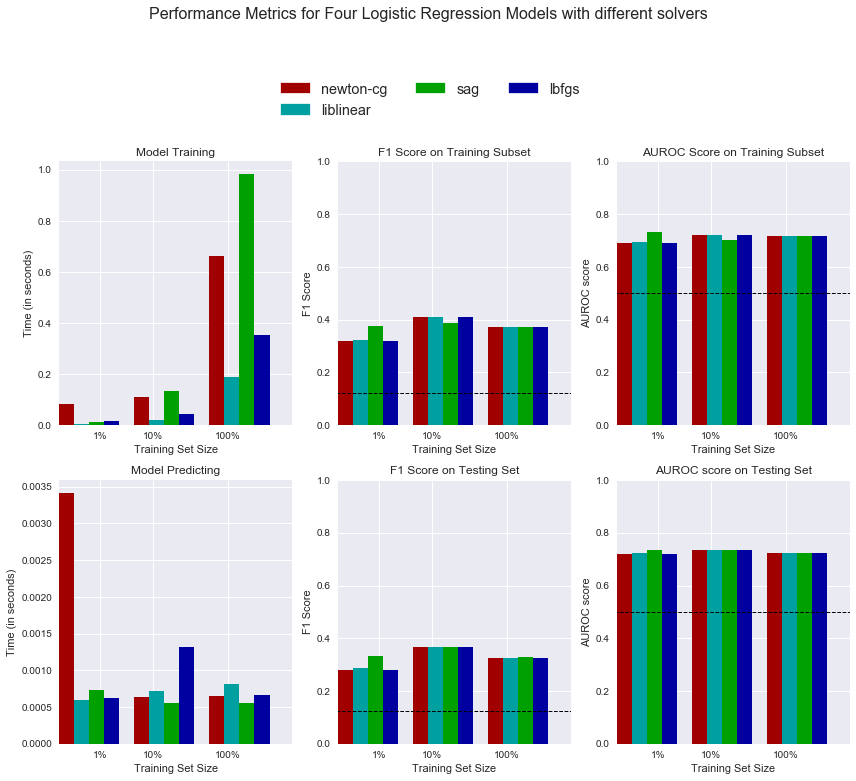

In [57]:
# solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
clf_A = LogisticRegression(random_state=42, class_weight='balanced', solver='newton-cg')
clf_B = LogisticRegression(random_state=42, class_weight='balanced', solver='lbfgs')
clf_C = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
clf_D = LogisticRegression(random_state=42, class_weight='balanced', solver='sag')


samples_100 = len(y_train)
samples_10 = len(y_train)/10
samples_1 = len(y_train)/100


# Collect results on the learners
results = {}
for idx, clf in enumerate([clf_A, clf_B, clf_C, clf_D]):
    clf_name = clf.solver
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate_tune(results, f1Score, aurocScore)